                                Mini Project 12_ANN (Heart Failure Prediction)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import yellowbrick
import pickle
from sklearn.svm import SVC
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from matplotlib.collections import PathCollection
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# --- Libraries Settings ---
pd.set_option("display.precision", 4)
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi']=100
     

%matplotlib inline
plt.rcParams.update({"font.size": 13, "figure.figsize": [8,4]})

# 1. Read Dataset

In [2]:
# Read the dataset
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Here, the target variable is `DEATH_EVENT`. That means, it is a binary classification problem.

# 2. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


From dataset description, we can see that:
- The shape of the dataset is (299, 13). 
- There are no missing values.
- The data type of `age` is float. We'll convert it to integer.

In [4]:
df["age"] = df["age"].astype(int)

In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000
mean,60.8294,0.4314,581.8395,0.4181,38.0836,0.3512,263358.0293,1.3939,136.6254,0.6488,0.3211,130.2609,0.3211
std,11.8950,0.4961,970.2879,0.4941,11.8348,0.4781,97804.2369,1.0345,4.4125,0.4781,0.4677,77.6142,0.4677
min,40.0000,0.0000,23.0000,0.0000,14.0000,0.0000,25100.0000,0.5000,113.0000,0.0000,0.0000,4.0000,0.0000
25%,51.0000,0.0000,116.5000,0.0000,30.0000,0.0000,212500.0000,0.9000,134.0000,0.0000,0.0000,73.0000,0.0000
50%,60.0000,0.0000,250.0000,0.0000,38.0000,0.0000,262000.0000,1.1000,137.0000,1.0000,0.0000,115.0000,0.0000
75%,70.0000,1.0000,582.0000,1.0000,45.0000,1.0000,303500.0000,1.4000,140.0000,1.0000,1.0000,203.0000,1.0000
max,95.0000,1.0000,7861.0000,1.0000,80.0000,1.0000,850000.0000,9.4000,148.0000,1.0000,1.0000,285.0000,1.0000


From dataset description, we can see that:
- `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, `smoking` and `DEATH_EVENT` are qualitative variables. One easy way to find out is to check the min and max values of those variables. We need to decode these variables.
- The rest are quantitative variables.
- Age is distributed between 40 to 95.

In [6]:
df["DEATH_EVENT"].value_counts(normalize=True)

0    0.6789
1    0.3211
Name: DEATH_EVENT, dtype: float64

We have approximately 68% False and 32% True values for DEATH_EVENT.

In [7]:
df["sex"].value_counts(normalize=True)

1    0.6488
0    0.3512
Name: sex, dtype: float64

We have approximately 65% Male and 35% Female in the dataset.

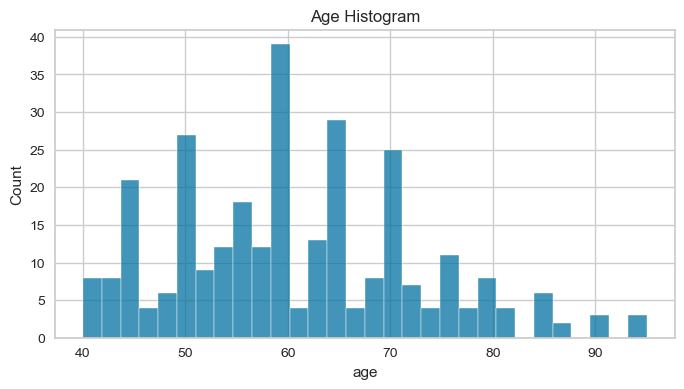

In [8]:
sns.histplot(df["age"], bins=30)
plt.title("Age Histogram")
plt.show()

For age, the median is around 60.

In [9]:
x = df.iloc[:,0:-1].values
y = df.iloc[:, -1].values

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Encode the 'sex' column
sex_encoded = encoder.fit_transform(df[['sex']])

# Convert the encoded column to a dense array
sex_array = sex_encoded.toarray()

# Replace the 'sex' column with the encoded array
df = df.drop(columns=['sex'])
df['male'] = sex_array[:, 1]  # Assuming '1' represents 'male'

# Now, you can proceed with StandardScaler
x = df.iloc[:, :-1].values


In [11]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=12)

In [12]:
model = keras.Sequential(
    [
      #  keras.layers.Flatten()
      keras.layers.Dense(units=16, activation=tf.keras.activations.relu, input_dim=12, name='Input_Layer'),
      keras.layers.Dense(units=8, activation=tf.keras.activations.relu, name='Hidden_Layer_1'),
      keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid, name='Output_Layer')
    ]
)
     

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Dense)         (None, 16)                208       
                                                                 
 Hidden_Layer_1 (Dense)      (None, 8)                 136       
                                                                 
 Output_Layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])


In [15]:

# Convert input features and target labels to appropriate data types
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# Then, train the model
hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100


8/8 [==============================] - 1s 33ms/step - loss: 6279.6895 - accuracy: 0.3138 - val_loss: 1512.8635 - val_accuracy: 0.3500
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 882.6599 - accuracy: 0.5941 - val_loss: 1295.0532 - val_accuracy: 0.6500
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 1376.7650 - accuracy: 0.6862 - val_loss: 872.9571 - val_accuracy: 0.6500
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 496.5286 - accuracy: 0.5732 - val_loss: 437.7155 - val_accuracy: 0.3500
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 215.5955 - accuracy: 0.5649 - val_loss: 156.7959 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 104.0648 - accuracy: 0.5272 - val_loss: 66.7311 - val_accuracy: 0.6667
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 78.2795 - accuracy: 0.5439 - val_loss: 82.6222 - val_accuracy:

8/8 [==============================] - 0s 13ms/step - loss: 74.6570 - accuracy: 0.5439 - val_loss: 160.4476 - val_accuracy: 0.3500
Epoch 56/100
8/8 [==============================] - 0s 11ms/step - loss: 145.4201 - accuracy: 0.5272 - val_loss: 27.8828 - val_accuracy: 0.6500
Epoch 57/100
8/8 [==============================] - 0s 11ms/step - loss: 93.5494 - accuracy: 0.5607 - val_loss: 87.4601 - val_accuracy: 0.6500
Epoch 58/100
8/8 [==============================] - 0s 9ms/step - loss: 77.7679 - accuracy: 0.5649 - val_loss: 166.8059 - val_accuracy: 0.6500
Epoch 59/100
8/8 [==============================] - 0s 13ms/step - loss: 122.4358 - accuracy: 0.5397 - val_loss: 139.6120 - val_accuracy: 0.6500
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 147.7411 - accuracy: 0.6151 - val_loss: 134.2526 - val_accuracy: 0.3500
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 69.4443 - accuracy: 0.6109 - val_loss: 17.7797 - val_accuracy: 0.6500
Epoch 62

In [16]:
# Train and Test accuracy
scores = model.evaluate(x_train, y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1] * 100))
scores = model.evaluate(x_test, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1] * 100))


8/8 [==============================] - 0s 4ms/step - loss: 36.3580 - accuracy: 0.6862
Training Accuracy: 68.62%

2/2 [==============================] - 0s 16ms/step - loss: 31.2404 - accuracy: 0.6500
Testing Accuracy: 65.00%



In [17]:
from keras.layers import Dropout

# Define the model
model = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_dim=12),
    keras.layers.Dropout(0.2),  # Adding dropout for regularization
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(0.2),  # Adding dropout for regularization
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 16829.5898 - accuracy: 0.6736 - val_loss: 10907.7051 - val_accuracy: 0.6500
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 14474.0586 - accuracy: 0.6360 - val_loss: 6810.9253 - val_accuracy: 0.6500
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 11642.2334 - accuracy: 0.5649 - val_loss: 3503.2156 - val_accuracy: 0.6500
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 7902.0352 - accuracy: 0.6025 - val_loss: 1798.3654 - val_accuracy: 0.6500
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 8170.7715 - accuracy: 0.5690 - val_loss: 1506.4128 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 8085.4077 - accuracy: 0.5565 - val_loss: 1687.4719 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 7099.2793 - accuracy: 0.5858 - val_loss: 1645.7643

Epoch 58/100
8/8 [==============================] - 0s 9ms/step - loss: 313.4239 - accuracy: 0.5607 - val_loss: 0.6601 - val_accuracy: 0.6500
Epoch 59/100
8/8 [==============================] - 0s 7ms/step - loss: 323.7690 - accuracy: 0.6820 - val_loss: 0.7389 - val_accuracy: 0.3500
Epoch 60/100
8/8 [==============================] - 0s 4ms/step - loss: 303.9321 - accuracy: 0.5481 - val_loss: 0.6513 - val_accuracy: 0.6500
Epoch 61/100
8/8 [==============================] - 0s 4ms/step - loss: 374.1459 - accuracy: 0.6485 - val_loss: 1.0591 - val_accuracy: 0.3500
Epoch 62/100
8/8 [==============================] - 0s 4ms/step - loss: 169.5363 - accuracy: 0.5523 - val_loss: 0.6983 - val_accuracy: 0.6500
Epoch 63/100
8/8 [==============================] - 0s 7ms/step - loss: 254.2679 - accuracy: 0.6862 - val_loss: 0.6432 - val_accuracy: 0.6500
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 254.2020 - accuracy: 0.5941 - val_loss: 0.6375 - val_accuracy: 0.6500
Epoch 

In [19]:
# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Evaluate the model on testing data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.2f}')


8/8 [==============================] - 0s 2ms/step - loss: 0.6559 - accuracy: 0.6862
Training Accuracy: 0.69
2/2 [==============================] - 0s 16ms/step - loss: 0.6645 - accuracy: 0.6500
Testing Accuracy: 0.65


Having a higher training accuracy compared to testing accuracy suggests that the model might be overfitting to the training data, meaning it's performing well on the training data but not generalizing well to unseen data.

To improve the model's performance and address potential overfitting, we can further tune hyperparameters, adjust the model architecture, or apply regularization techniques like dropout.

In [20]:
# Define the model with dropout regularization
model_with_dropout = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_dim=12),
    keras.layers.Dropout(0.2),  # Dropout rate of 0.2 after the first hidden layer
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(0.2),  # Dropout rate of 0.2 after the second hidden layer
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model_with_dropout.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

# Print the summary of the model
print(model_with_dropout.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                416       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [21]:
# Train the model
history_dropout = model_with_dropout.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100
8/8 [==============================] - 1s 29ms/step - loss: 21755.4727 - accuracy: 0.3305 - val_loss: 16760.1836 - val_accuracy: 0.3500
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 12985.9307 - accuracy: 0.3808 - val_loss: 11202.4463 - val_accuracy: 0.3500
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 9067.4473 - accuracy: 0.4519 - val_loss: 4232.4775 - val_accuracy: 0.3500
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 7398.8115 - accuracy: 0.4770 - val_loss: 734.3812 - val_accuracy: 0.6500
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 5893.9819 - accuracy: 0.5774 - val_loss: 1977.0775 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 4927.3286 - accuracy: 0.6402 - val_loss: 1620.3918 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 4926.8389 - accuracy: 0.5397 - val_loss: 886.2618 

8/8 [==============================] - 0s 9ms/step - loss: 215.4829 - accuracy: 0.6611 - val_loss: 0.6659 - val_accuracy: 0.6500
Epoch 59/100
8/8 [==============================] - 0s 9ms/step - loss: 34.8932 - accuracy: 0.6904 - val_loss: 0.6655 - val_accuracy: 0.6500
Epoch 60/100
8/8 [==============================] - 0s 9ms/step - loss: 40.1145 - accuracy: 0.6611 - val_loss: 0.6650 - val_accuracy: 0.6500
Epoch 61/100
8/8 [==============================] - 0s 11ms/step - loss: 57.9194 - accuracy: 0.6778 - val_loss: 0.6645 - val_accuracy: 0.6500
Epoch 62/100
8/8 [==============================] - 0s 11ms/step - loss: 130.7071 - accuracy: 0.6695 - val_loss: 0.6640 - val_accuracy: 0.6500
Epoch 63/100
8/8 [==============================] - 0s 13ms/step - loss: 82.9864 - accuracy: 0.6695 - val_loss: 0.6635 - val_accuracy: 0.6500
Epoch 64/100
8/8 [==============================] - 0s 11ms/step - loss: 199.1843 - accuracy: 0.6611 - val_loss: 0.6630 - val_accuracy: 0.6500
Epoch 65/100
8/8 [=

In [22]:
# Evaluate the model on training data
train_loss_dropout, train_accuracy_dropout = model_with_dropout.evaluate(x_train, y_train)
print(f'Training Accuracy (with dropout): {train_accuracy_dropout:.2f}')

# Evaluate the model on testing data
test_loss_dropout, test_accuracy_dropout = model_with_dropout.evaluate(x_test, y_test)
print(f'Testing Accuracy (with dropout): {test_accuracy_dropout:.2f}')


8/8 [==============================] - 0s 2ms/step - loss: 0.6367 - accuracy: 0.6862
Training Accuracy (with dropout): 0.69
2/2 [==============================] - 0s 16ms/step - loss: 0.6520 - accuracy: 0.6500
Testing Accuracy (with dropout): 0.65


In [23]:
from keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history_early_stopping = model_with_dropout.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 28.6687 - accuracy: 0.6820 - val_loss: 0.6518 - val_accuracy: 0.6500
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 15.9075 - accuracy: 0.6820 - val_loss: 0.6516 - val_accuracy: 0.6500
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 26.3040 - accuracy: 0.6820 - val_loss: 0.6514 - val_accuracy: 0.6500
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 87.0774 - accuracy: 0.6736 - val_loss: 0.6513 - val_accuracy: 0.6500
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 34.3355 - accuracy: 0.6862 - val_loss: 0.6511 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 22.6067 - accuracy: 0.6778 - val_loss: 0.6509 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6426 - accuracy: 0.6862 - val_loss: 0.6508 - val_accuracy: 0.6500
Epoch 8/100
8/8 [=

8/8 [==============================] - 0s 4ms/step - loss: 93.8500 - accuracy: 0.6820 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 34.9664 - accuracy: 0.6778 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 4.8501 - accuracy: 0.6904 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 9.5301 - accuracy: 0.6778 - val_loss: 0.6475 - val_accuracy: 0.6500
Epoch 63/100
8/8 [==============================] - 0s 7ms/step - loss: 4.0478 - accuracy: 0.6862 - val_loss: 0.6475 - val_accuracy: 0.6500
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 1.0413 - accuracy: 0.6862 - val_loss: 0.6475 - val_accuracy: 0.6500
Epoch 65/100
8/8 [==============================] - 0s 9ms/step - loss: 39.0634 - accuracy: 0.6862 - val_loss: 0.6475 - val_accuracy: 0.6500
Epoch 66/100
8/8 [============

In [24]:
# Evaluate the model on training data with early stopping
train_loss_early_stopping, train_accuracy_early_stopping = model_with_dropout.evaluate(x_train, y_train)
print(f'Training Accuracy (with early stopping): {train_accuracy_early_stopping:.2f}')

# Evaluate the model on testing data with early stopping
test_loss_early_stopping, test_accuracy_early_stopping = model_with_dropout.evaluate(x_test, y_test)
print(f'Testing Accuracy (with early stopping): {test_accuracy_early_stopping:.2f}')


8/8 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6862
Training Accuracy (with early stopping): 0.69
2/2 [==============================] - 0s 0s/step - loss: 0.6474 - accuracy: 0.6500
Testing Accuracy (with early stopping): 0.65


The training and testing accuracies with early stopping are similar to the accuracies without early stopping. This suggests that early stopping might not have a significant impact on the model's performance for this dataset.

In [25]:
# Define the model with increased number of neurons
model_with_increased_neurons = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_dim=12),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model_with_increased_neurons.compile(optimizer='adam',
                                     loss='binary_crossentropy',
                                     metrics=['accuracy'])

# Print the summary of the model
print(model_with_increased_neurons.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                832       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
# Train the model with increased number of neurons
history_increased_neurons = model_with_increased_neurons.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on training data with increased number of neurons
train_loss_increased_neurons, train_accuracy_increased_neurons = model_with_increased_neurons.evaluate(x_train, y_train)
print(f'Training Accuracy (with increased neurons): {train_accuracy_increased_neurons:.2f}')

# Evaluate the model on testing data with increased number of neurons
test_loss_increased_neurons, test_accuracy_increased_neurons = model_with_increased_neurons.evaluate(x_test, y_test)
print(f'Testing Accuracy (with increased neurons): {test_accuracy_increased_neurons:.2f}')


Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 8160.9556 - accuracy: 0.4812 - val_loss: 2797.1890 - val_accuracy: 0.6500
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 5990.1885 - accuracy: 0.6067 - val_loss: 3754.5110 - val_accuracy: 0.6500
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 4785.5674 - accuracy: 0.5565 - val_loss: 1630.4297 - val_accuracy: 0.6500
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 4138.1489 - accuracy: 0.5816 - val_loss: 846.9542 - val_accuracy: 0.6500
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 5494.1787 - accuracy: 0.4854 - val_loss: 858.4142 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 4447.7534 - accuracy: 0.5146 - val_loss: 1171.3201 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 4536.7266 - accuracy: 0.5063 - val_loss: 1320.8575 - val_

8/8 [==============================] - 0s 7ms/step - loss: 88.2613 - accuracy: 0.4979 - val_loss: 0.6211 - val_accuracy: 0.6500
Epoch 59/100
8/8 [==============================] - 0s 7ms/step - loss: 35.0273 - accuracy: 0.6736 - val_loss: 0.7529 - val_accuracy: 0.3500
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 44.5373 - accuracy: 0.6109 - val_loss: 0.6749 - val_accuracy: 0.6500
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 80.8333 - accuracy: 0.5272 - val_loss: 0.6323 - val_accuracy: 0.6500
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 45.9787 - accuracy: 0.6611 - val_loss: 0.8381 - val_accuracy: 0.3500
Epoch 63/100
8/8 [==============================] - 0s 7ms/step - loss: 50.4035 - accuracy: 0.5523 - val_loss: 0.6181 - val_accuracy: 0.6500
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 22.4052 - accuracy: 0.6067 - val_loss: 0.7469 - val_accuracy: 0.6500
Epoch 65/100
8/8 [========

In [27]:
# Train the model with increased number of neurons
history_increased_neurons = model_with_increased_neurons.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on training data with increased number of neurons
train_loss_increased_neurons, train_accuracy_increased_neurons = model_with_increased_neurons.evaluate(x_train, y_train)
print(f'Training Accuracy (with increased neurons): {train_accuracy_increased_neurons:.2f}')

# Evaluate the model on testing data with increased number of neurons
test_loss_increased_neurons, test_accuracy_increased_neurons = model_with_increased_neurons.evaluate(x_test, y_test)
print(f'Testing Accuracy (with increased neurons): {test_accuracy_increased_neurons:.2f}')


Epoch 1/100
8/8 [==============================] - 0s 13ms/step - loss: 69.4396 - accuracy: 0.6527 - val_loss: 0.7889 - val_accuracy: 0.3500
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 109.1095 - accuracy: 0.6234 - val_loss: 1.2367 - val_accuracy: 0.3500
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 72.3144 - accuracy: 0.5397 - val_loss: 0.7574 - val_accuracy: 0.6500
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 28.8762 - accuracy: 0.5941 - val_loss: 0.7155 - val_accuracy: 0.3333
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 7.9533 - accuracy: 0.6151 - val_loss: 0.6412 - val_accuracy: 0.6500
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 43.2418 - accuracy: 0.6234 - val_loss: 1.1018 - val_accuracy: 0.3500
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 31.0513 - accuracy: 0.6360 - val_loss: 0.6370 - val_accuracy: 0.6500
Epoch 8/100
8/8 [==

The training and testing accuracies are similar to the previous model's performance, indicating that increasing the number of neurons did not lead to significant improvement in generalization.